In [198]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [199]:
#data read/create dfs
prices_df = pd.read_csv('raw-data/egg-prices.csv')
production_df = pd.read_csv('raw-data/egg-production.csv')

In [200]:
#eda for prices_df
print(prices_df.head())
print(prices_df.tail())
print(prices_df.shape)
print(prices_df.columns)
print(prices_df.dtypes)
print(prices_df.describe(include='all'))

   YEAR  LOCATION STATE ANSI ASD CODE COUNTY ANSI REFERENCE PERIOD COMMODITY  \
0  2016  US TOTAL                                              JAN      EGGS   
1  2016  US TOTAL                                              FEB      EGGS   
2  2016  US TOTAL                                              MAR      EGGS   
3  2016  US TOTAL                                              APR      EGGS   
4  2016  US TOTAL                                              MAY      EGGS   

   ALL UTILIZATION PRACTICES in $ / DOZEN  \
0                                   1.180   
1                                   1.080   
2                                   0.970   
3                                   0.680   
4                                   0.552   

   ALL UTILIZATION PRACTICES, TABLE in $ / DOZEN  
0                                          0.969  
1                                          0.850  
2                                          0.731  
3                                          0

In [201]:
#eda for production_df
print(production_df.head())
print(production_df.tail())
print(production_df.shape)
print(production_df.columns)
print(production_df.dtypes)
print(production_df.describe(include='all'))

  Program  Year Period  Week Ending Geo Level     State  State ANSI  \
0  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
1  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
2  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
3  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
4  SURVEY  2021    APR          NaN     STATE  ARKANSAS         5.0   

   Ag District  Ag District Code  County  ...  Zip Code  Region  \
0          NaN               NaN     NaN  ...       NaN     NaN   
1          NaN               NaN     NaN  ...       NaN     NaN   
2          NaN               NaN     NaN  ...       NaN     NaN   
3          NaN               NaN     NaN  ...       NaN     NaN   
4          NaN               NaN     NaN  ...       NaN     NaN   

   watershed_code  Watershed  Commodity  \
0               0        NaN       EGGS   
1               0        NaN       EGGS   
2               0        NaN       EGGS  

In [202]:
#examining nulls
print(prices_df.isnull().sum())
print(production_df.isnull().sum())

YEAR                                             0
LOCATION                                         0
STATE ANSI                                       0
ASD CODE                                         0
COUNTY ANSI                                      0
REFERENCE PERIOD                                 0
COMMODITY                                        0
ALL UTILIZATION PRACTICES in $ / DOZEN           0
ALL UTILIZATION PRACTICES, TABLE in $ / DOZEN    0
dtype: int64
Program                0
Year                   0
Period                 0
Week Ending         8212
Geo Level              0
State                  0
State ANSI           288
Ag District         8212
Ag District Code    8212
County              8212
County ANSI         8212
Zip Code            8212
Region              8212
watershed_code         0
Watershed           8212
Commodity              0
Data Item              0
Domain                 0
Domain Category        0
Value                  0
CV (%)              8212
dty

In [203]:
#cleaning production_df

#drop unneccessary and empty columns
production_df = production_df.drop(columns=['Program', 'Week Ending', 'Ag District', 'Geo Level', 'Ag District Code', 'County', 'County ANSI', 'Zip Code', 'Region', 'watershed_code', 
                                            'Watershed', 'Commodity', 'Domain', 'Domain Category', 'CV (%)'])

#drop rows with (D) under Value column, represents no data. strip used because there is a space in front of (D).
production_df = production_df[production_df['Value'].str.strip() != '(D)']

#changing 'Value' column dtype to int instead of object for later calculations.
production_df['Value'] = production_df['Value'].str.replace(',', '').astype(int)

#'State ANSI' nulls represent 'OTHER STATES' in 'State' column, dropping these rows
production_df = production_df[production_df['State'] != 'OTHER STATES']

#need to match unit of measurement with prices_df, removing rows not measured by the dozen.
production_df = production_df[~production_df['Data Item'].str.contains('MEASURED IN EGGS')]

#'State Ansi' dtype change from float64 to int64 to remove decimals
production_df['State ANSI'] = production_df['State ANSI'].astype(int)

#rename columns for clarity and consistency
production_df.columns = ['Year', 'Month', 'State', 'State Identifier', 'Egg Type', 'Production in Dozens']

print(production_df.head())


    Year Month     State  State Identifier  \
0   2021   APR   ALABAMA                 1   
2   2021   APR   ALABAMA                 1   
16  2021   APR   GEORGIA                13   
18  2021   APR   GEORGIA                13   
20  2021   APR  ILLINOIS                17   

                                          Egg Type  Production in Dozens  
0   EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              13241700  
2      EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN               3025000  
16  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              15958400  
18     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN              19200000  
20  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN                291700  


In [204]:
#clean prices_df

#drop unnecessary columns
prices_df = prices_df.drop(columns=['LOCATION', 'STATE ANSI', 'ASD CODE', 'COUNTY ANSI', 'COMMODITY'])

#rename columns for clarity and consistency
prices_df.columns = ['Year', 'Month', 'Price($) per Dozen (All Types)', 'Price per Dozen (Table)']
print(prices_df.head())

   Year Month  Price($) per Dozen (All Types)  Price per Dozen (Table)
0  2016   JAN                           1.180                    0.969
1  2016   FEB                           1.080                    0.850
2  2016   MAR                           0.970                    0.731
3  2016   APR                           0.680                    0.391
4  2016   MAY                           0.552                    0.242


In [205]:
#sqlite database creation

#create connection
conn = sqlite3.connect('egg_data.db')
cursor = conn.cursor()

#create production table
cursor.execute("""
CREATE TABLE IF NOT EXISTS production (
    Year INTEGER,
    Month TEXT,
    State TEXT,
    "State Identifier" INTEGER,
    "Egg Type" TEXT,
    "Production in Dozens" INTEGER,
    PRIMARY KEY (Year, Month)
)
""")

#create prices table
cursor.execute("""
CREATE TABLE IF NOT EXISTS prices (
    Year INTEGER,
    Month TEXT,
    State TEXT,
    "Price($) per Dozen (All Types)" REAL,
    "Price per Dozen (Table)" REAL,
    PRIMARY KEY (Year, Month)
)
""")

#insert data into tables
production_df.to_sql("production", conn, if_exists="replace", index=False)
prices_df.to_sql("prices", conn, if_exists="replace", index=False)

#verify tables
print(pd.read_sql_query("SELECT * FROM production", conn))
print(pd.read_sql_query("SELECT * FROM prices", conn))

      Year Month         State  State Identifier  \
0     2021   APR       ALABAMA                 1   
1     2021   APR       ALABAMA                 1   
2     2021   APR       GEORGIA                13   
3     2021   APR       GEORGIA                13   
4     2021   APR      ILLINOIS                17   
...    ...   ...           ...               ...   
2513  2016   SEP  SOUTH DAKOTA                46   
2514  2016   SEP          UTAH                49   
2515  2016   SEP          UTAH                49   
2516  2016   SEP      VIRGINIA                51   
2517  2016   SEP      VIRGINIA                51   

                                            Egg Type  Production in Dozens  
0     EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              13241700  
1        EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN               3025000  
2     EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              15958400  
3        EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN              1

In [206]:
#join production and prices tables
query = """
SELECT 
    prices.Year, 
    prices.Month, 
    prices."Price($) per Dozen (All Types)", 
    prices."Price per Dozen (Table)", 
    production.State, 
    production."State Identifier", 
    production."Egg Type", 
    production."Production in Dozens" 
FROM prices
JOIN production
ON production.Month = prices.Month AND production.Year = prices.Year;
"""

joined_df = pd.read_sql_query(query, conn)
print(joined_df.head())
joined_df.to_csv('output.csv')

   Year Month  Price($) per Dozen (All Types)  Price per Dozen (Table)  \
0  2016   JAN                            1.18                    0.969   
1  2016   JAN                            1.18                    0.969   
2  2016   JAN                            1.18                    0.969   
3  2016   JAN                            1.18                    0.969   
4  2016   JAN                            1.18                    0.969   

      State  State Identifier                                        Egg Type  \
0   ALABAMA                 1  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   
1   ALABAMA                 1     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN   
2  ARKANSAS                 5  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   
3  ARKANSAS                 5     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN   
4   FLORIDA                12  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   

   Production in Dozens  
0              11641700  
1               

Possible things to visualize:
- Top producers by state/year
- Production and prices over time
- Hatching to table comparisons
- Top producing states by egg type
- Seasonal trends in production and pricing

   Year Month  Price($) per Dozen (All Types)  Price per Dozen (Table)  \
0  2016   JAN                            1.18                    0.969   
1  2016   JAN                            1.18                    0.969   
2  2016   JAN                            1.18                    0.969   
3  2016   JAN                            1.18                    0.969   
4  2016   JAN                            1.18                    0.969   

      State  State Identifier                                        Egg Type  \
0   ALABAMA                 1  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   
1   ALABAMA                 1     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN   
2  ARKANSAS                 5  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   
3  ARKANSAS                 5     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN   
4   FLORIDA                12  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   

   Production in Dozens  TotalProduction  
0              11641700  

<Axes: ylabel='State'>

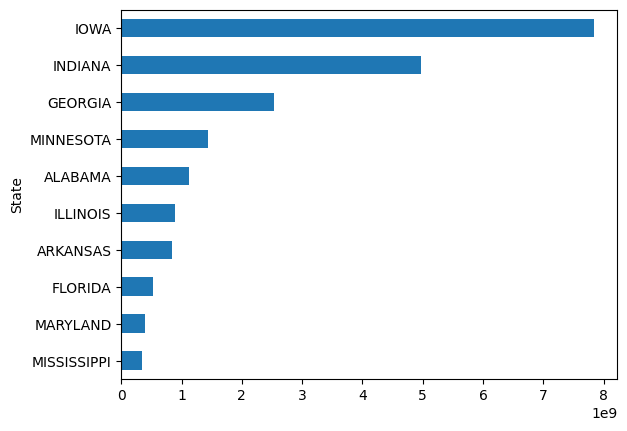

In [207]:
#top producers by state

#new column for total production by state
joined_df['TotalProduction'] = joined_df.groupby('State')['Production in Dozens'].transform('sum')
print(joined_df.head())

#plot
top_states = joined_df.groupby('State')['TotalProduction'].max().head(10).sort_values(ascending=True)
top_states.plot.barh()
